# Adversarial Attack Test

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision.transforms import ToTensor
from torch.optim import Adam

from context import *
from LocalLearning import Attacks
from LocalLearning import KHModel
from LocalLearning import Data
from LocalLearning import Trainers

from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
plt.style.use(['seaborn-paper', "./PRLDoubleCol.mplstyle"])

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# train Flipswitch
TRAIN = False

# hyper-parameter
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000

model_path = Path("../data/models/CIFAR10_PowerLaw")
figure_path = Path("../data/figures/CIFAR10_PowerLaw")

model_ps = {
    "in_size": 3*32**2,
    "hidden_size": 2000,
    "n": 4.5,
    "p": 3.0,
    "tau_l": 1.0 / 0.02, # 1 / learning_rate
    "k": 2,
    "Delta": 0.4,
    "R": 1.0,
}

In [4]:
# load the model
model_file = Path("kh_cifar10_pruned_thr.pty")
filepath = model_path / model_file

if os.path.isfile(filepath):
    storage_obj = torch.load(filepath)

with torch.no_grad():
    model_pset = storage_obj["model_parameters"]
    dummy = LocalLearning.FKHL3(model_pset)
    dummy.load_state_dict(storage_obj["model_state_dict"])
    khlayer = LocalLearning.FKHL3(model_pset)
    khlayer.W = torch.nn.Parameter(dummy.W.clone())
    khlayer.to(device)
    khlayer.eval()

# Train the hybrid model

In [5]:
khmodel = KHModel(khlayer)
khmodel.to(device)
khmodel.train()

In [6]:
# Hyper parameters:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-4

In [7]:
cifar10Train= Data.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=True,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

TrainLoader = Data.DeviceDataLoader(
    cifar10Train,# define batch window in the global index coordinates
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

cifar10Test = Data.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=khlayer.pSet["p"],
)

TestLoader = Data.DeviceDataLoader(
    cifar10Test,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
TRAIN = False
if TRAIN:
    ce_trainer = Trainers.CETrainer(khmodel, device)
    ce_trainer.run(TrainLoader, TestLoader, no_epochs=NUMBER_OF_EPOCHS)
    # save the model
    torch.save(
        {
            "fkhl3-path": str(filepath),
            "fkhl3-state": storage_obj,
            "model_state_dict": khmodel.state_dict(),
            "loss_history": ce_trainer.log["loss"],
            "accuracy_history": ce_trainer.log["eval_acc"],
        },
        model_path / Path("KHModel_" + str(model_file)),
    )

In [9]:
if TRAIN:
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(ce_trainer.log["ce_loss"])
    axs[0].set_xlabel(r"t [epochs]")
    axs[0].set_ylabel(r"CE(t)")
    axs[1].plot(ce_trainer.log["eval_acc"])
    axs[1].set_xlabel(r"t [epochs]")
    axs[1].set_ylabel(r"Accuracy(t)")

# Adversarial Testing

In [10]:
khmodel_filepath = model_path / Path("KHModel_" + str(model_file))
storage_obj = torch.load(khmodel_filepath)
khmodel = KHModel(storage_obj)
khmodel.to(device)
khmodel.eval()

In [11]:
from torch.nn import CrossEntropyLoss
ce_loss = CrossEntropyLoss()

In [12]:
from LocalLearning.Attacks import FGSM
fgsm = FGSM(khmodel)

In [13]:
features, labels = next(iter(TestLoader))

In [14]:
a_example = fgsm(5e-2, features, labels, ce_loss)

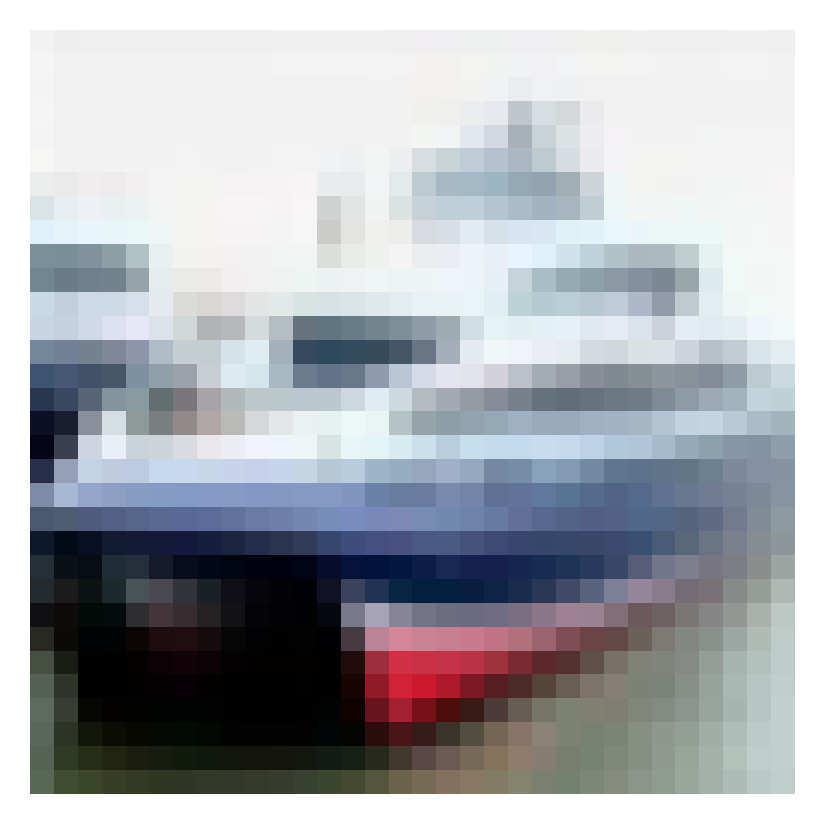

In [15]:
def minmaxnorm(a):
    a_ = a - a.min()
    return a_ / a_.max()

plt.figure()
#nc = np.max()
img = features[1].detach().cpu().numpy()
img = minmaxnorm(img)
im = plt.imshow(img, vmin=np.min(img), vmax=np.max(img))
plt.axis('off')
plt.show()

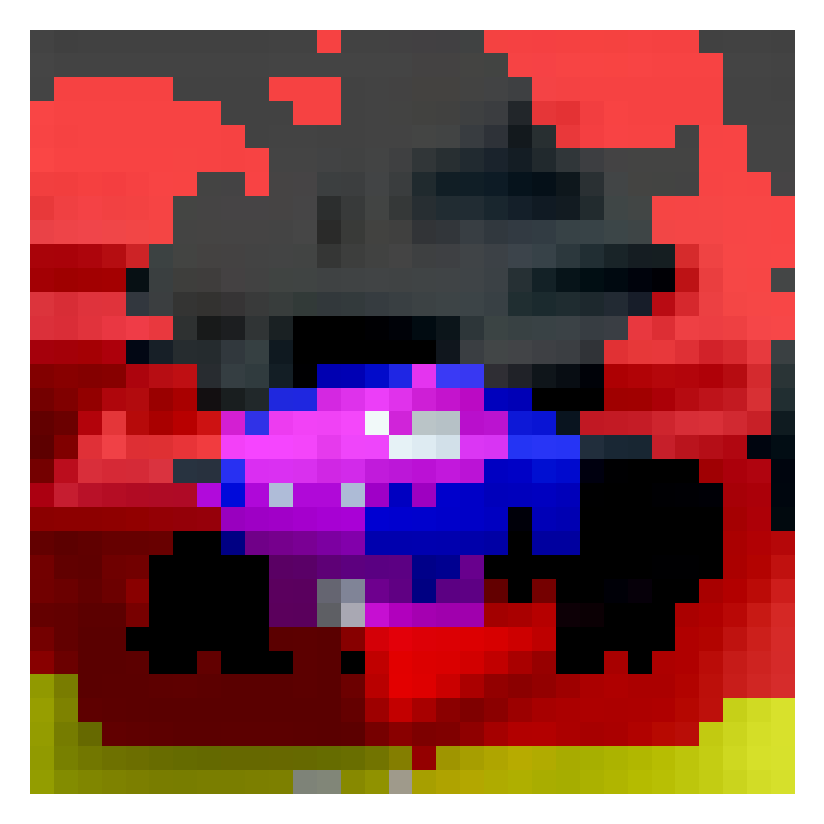

In [16]:
plt.figure()
#nc = np.max()
img = a_example[1].detach().cpu().numpy()
img = minmaxnorm(img)
im = plt.imshow(img, vmin=np.min(img), vmax=np.max(img))
plt.axis('off')
plt.show()

In [104]:
from LocalLearning.Attacks import PGD, FGSM, WhiteGaussianPerturbation

# PGD
pgd_params = {
    "num_it": 20,
    "dl": 1e-2,
    "dl_deps": 1e-1,
    "norm_p": 'inf',
}
pgd = PGD(khmodel, pgd_params)

# FGSM
fgsm = FGSM(khmodel)

# random perturbation
rp = WhiteGaussianPerturbation(khmodel)

In [105]:
aTestData = Data.BaselineAccurateTestData(khmodel, cifar10Test)
aTestLoader = Data.DeviceDataLoader(
    aTestData,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
)

  0%|          | 0/10000 [00:00<?, ?batch/s]

In [106]:
fgsmTest = Attacks.AttackTest(fgsm, khmodel, ce_loss)
pgdTest = Attacks.AttackTest(pgd, khmodel, ce_loss)
rpTest = Attacks.AttackTest(rp, khmodel, ce_loss)

eps_highres = np.linspace(1e-6, 5e-2, num=200)
eps_lowres = np.linspace(1e-6, 20.0, num=200)
acc_fgsm, crit_eps_fgsm, crit_norm_fgsm = fgsmTest.run(aTestLoader, eps_highres, norm_p=2.0)
acc_pgd, crit_eps_pgd, crit_norm_pgd = pgdTest.run(aTestLoader, eps_highres, norm_p=2.0)
acc_rp, crit_eps_rp, crit_norm_rp = rpTest.run(aTestLoader, eps_lowres, norm_p=2.0)

  0%|          | 0/200 [00:00<?, ?perturbation/s]

  0%|          | 0/200 [00:00<?, ?perturbation/s]

  0%|          | 0/200 [00:00<?, ?perturbation/s]

In [107]:
nan_eps_fgsm = np.isnan(crit_eps_fgsm)
nan_eps_pgd = np.isnan(crit_eps_pgd)
nan_norm_fgsm = np.isnan(crit_norm_fgsm)
nan_norm_pgd = np.isnan(crit_norm_pgd)
nan_eps_rp = np.isnan(crit_eps_rp)
nan_norm_rp = np.isnan(crit_norm_rp)

eps_fgsm = crit_eps_fgsm[~nan_eps_fgsm]
eps_pgd = crit_eps_pgd[~nan_eps_pgd]
norm_fgsm = crit_norm_fgsm[~nan_norm_fgsm]
norm_pgd = crit_norm_pgd[~nan_norm_pgd]
eps_rp = crit_eps_rp[~nan_eps_rp]
norm_rp = crit_norm_rp[~nan_norm_rp]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd2521a19d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd2521a1f70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd2521a1700>,
 'medians': [<matplotlib.lines.Line2D at 0x7fd2521ae550>,
 'fliers': [],
 'means': []}

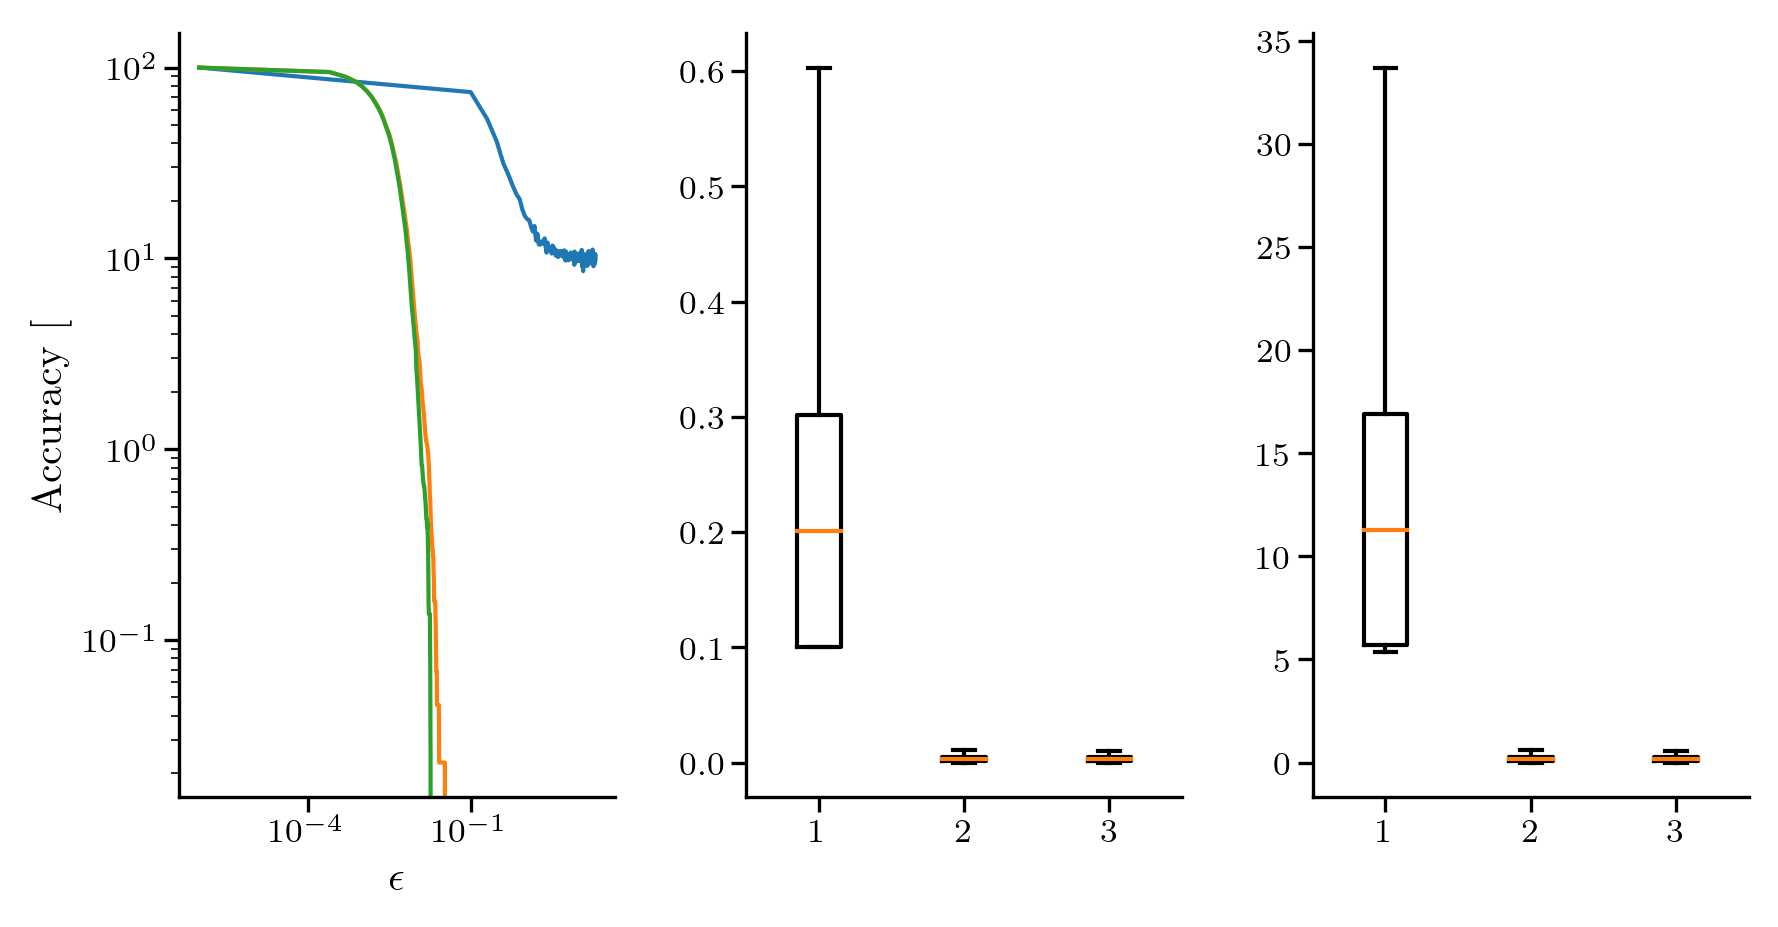

In [108]:
fig, axs = plt.subplots(1, 3)
axs[0].loglog(np.array(eps_lowres), 100*np.array(acc_rp))
axs[0].loglog(np.array(eps_highres), 100*np.array(acc_fgsm))
axs[0].loglog(np.array(eps_highres), 100*np.array(acc_pgd))
axs[0].set_xlabel(r"$\epsilon$")
axs[0].set_ylabel(r"Accuracy [%]")

axs[1].boxplot([eps_rp, eps_fgsm, eps_pgd], showfliers=False)

axs[2].boxplot([norm_rp, norm_fgsm, norm_pgd], showfliers=False)

In [23]:
adv_x = fgsm(5e-2, data, targets, ce_loss)

In [24]:
norms = torch.norm(torch.flatten(adv_x, start_dim=1), p=2.0, dim=-1)

In [25]:
adv_x = adv_x.T 
adv_x /= norms[..., :]
adv_x = adv_x.T

In [26]:
torch.norm(torch.flatten(adv_x[:10], start_dim=1), p=2.0, dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')

In [27]:
tuple(adv_x.size())

(1000, 32, 32, 3)

In [28]:
from LocalLearning.Attacks import PGD
pgd_params = {
    "num_it": 10,
    "dl": 1e-2,
    "norm_p": 'inf',
}
pgd = PGD(khmodel, pgd_params)

In [29]:
khmodel.eval()
adv_img = pgd(5e-2, data, targets, ce_loss)

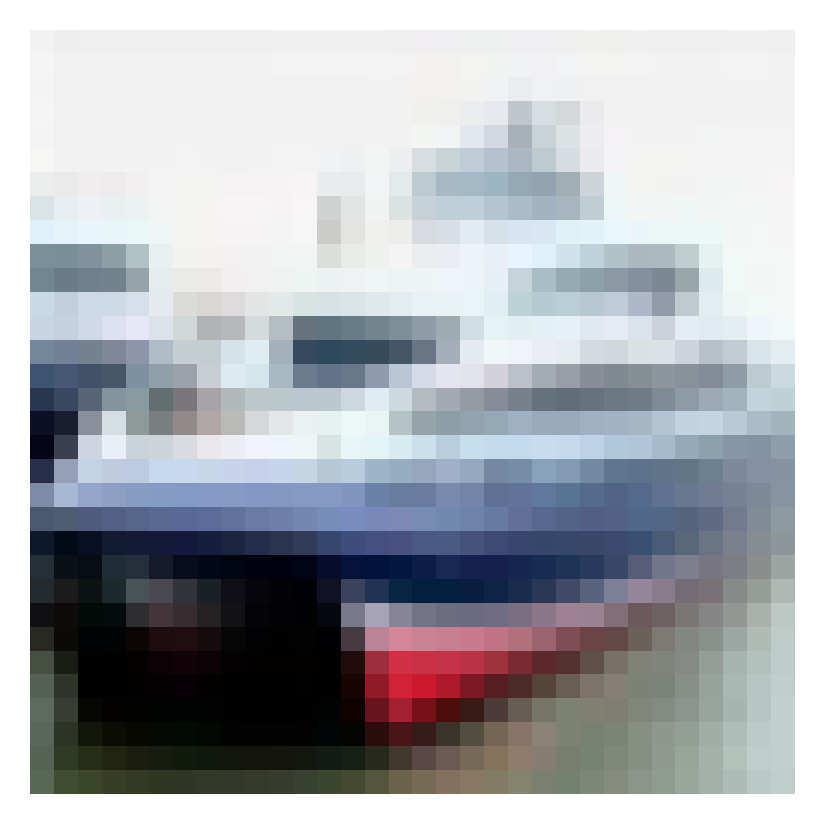

In [30]:
plt.figure()
#nc = np.max()
img = torch.clamp(data[1], 0.0, 1.0).detach().cpu().numpy()
img = minmaxnorm(img)
im = plt.imshow(img, vmin=np.min(img), vmax=np.max(img))
plt.axis('off')
plt.show()

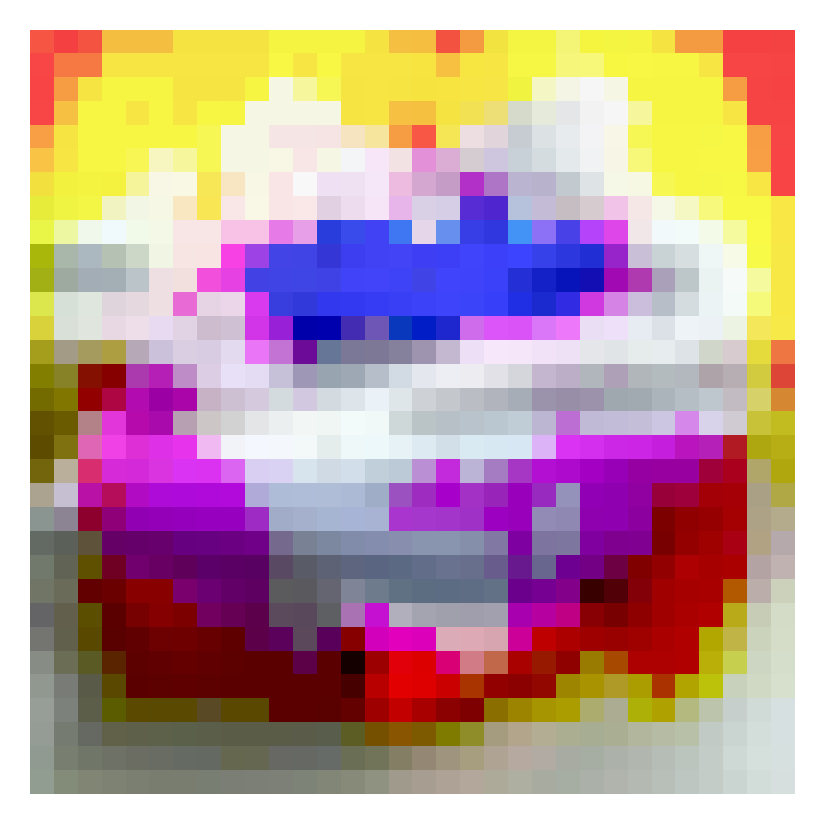

In [31]:
plt.figure()
#nc = np.max()
img = adv_img[1].detach().cpu().numpy()
img = minmaxnorm(img)
im = plt.imshow(img, vmin=np.min(img), vmax=np.max(img))
plt.axis('off')
plt.show()